<a href="https://colab.research.google.com/github/mehlika-dogan/DSA---210-Term-Project/blob/main/F1_Data_Cleaning_2010_2024_WinnerOnly_300Rows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# F1 Data Cleaning (2010–2024)
In this part of the project, I constructed a clean, ready for analysis dataset by combining multiple sources of Formula 1 data from 2010 to 2024. I collected information on races, drivers, results, pit stop logs, and weather conditions. And I filtered the data to include only races from 2010 to 2024 and focused on the winners of each Grand Prix. For each of these 300 races, I added key variables such as the winner's starting grid position, number of pit stops, weather conditions during the race, and basic driver info like name, nationality and date of birth. Where detailed pit stop data was missing, fallback values from summary statistics were used. The final result is a clean dataset with approximately 300 rows - one for each race - that includes variables I will analyze in the next steps.


In [1]:
import pandas as pd

# GitHub raw base
base_raw_url = "https://raw.githubusercontent.com/mehlika-dogan/DSA---210-Term-Project/main/data/"

# Load data
drivers = pd.read_csv(base_raw_url + "drivers.csv")
races = pd.read_csv(base_raw_url + "races.csv")
results = pd.read_csv(base_raw_url + "results.csv")
pit_stops = pd.read_csv(base_raw_url + "pit_stops.csv")
weather = pd.read_csv(base_raw_url + "F1%20Races%202020-2024.csv")
pit_summary = pd.read_csv(base_raw_url + "Formula1_Pitstop_Data_1950-2024_all_rounds.csv")

# Full name column
drivers['full_name'] = drivers['forename'].str.strip() + ' ' + drivers['surname'].str.strip()

# Filter races
races = races[(races['year'] >= 2010) & (races['year'] <= 2024)]

# Get race winners
winners = results[results['positionOrder'] == 1][['raceId', 'driverId', 'grid']].drop_duplicates('raceId')
winners.rename(columns={'driverId': 'winner_driverId', 'grid': 'winner_grid_position'}, inplace=True)

# Pit stop counts from detailed log
pit_counts = pit_stops.groupby(['raceId', 'driverId']).size().reset_index(name='pit_stop_count')

# Merge everything
df = races.merge(winners, on='raceId')
df = df.merge(pit_counts, left_on=['raceId', 'winner_driverId'], right_on=['raceId', 'driverId'], how='left')
df = df.merge(drivers, left_on='winner_driverId', right_on='driverId', how='left')

# Fallback: summary pit stops using full name
pit_summary.rename(columns={'Season': 'year', 'Round': 'round'}, inplace=True)
pit_summary['Driver'] = pit_summary['Driver'].str.strip()
df = df.merge(pit_summary[['year', 'round', 'Driver', 'TotalPitStops']],
              left_on=['year', 'round', 'full_name'], right_on=['year', 'round', 'Driver'], how='left')
df['pit_stop_count'] = df['pit_stop_count'].fillna(df['TotalPitStops'])

# Add weather
df = df.merge(weather[['raceId', 'rainy']], on='raceId', how='left')
df['rainy'] = df['rainy'].fillna('unknown')

# Final frame
final_df = df[[
    'raceId', 'year', 'round', 'name', 'date',
    'winner_driverId', 'forename', 'surname', 'full_name', 'dob', 'nationality',
    'winner_grid_position', 'pit_stop_count', 'rainy'
]].drop_duplicates('raceId')

final_df.head()


,raceId,year,round,name,date,winner_driverId,forename,surname,full_name,dob,nationality,winner_grid_position,pit_stop_count,rainy
0,337,2010,1,Bahrain Grand Prix,2010-03-14,4,Fernando,Alonso,Fernando Alonso,1981-07-29,Spanish,3,0.0,0.0
24,338,2010,2,Australian Grand Prix,2010-03-28,18,Jenson,Button,Jenson Button,1980-01-19,British,4,0.0,1.0
48,339,2010,3,Malaysian Grand Prix,2010-04-04,20,Sebastian,Vettel,Sebastian Vettel,1987-07-03,German,3,0.0,0.0
72,340,2010,4,Chinese Grand Prix,2010-04-18,18,Jenson,Button,Jenson Button,1980-01-19,British,5,0.0,1.0
96,341,2010,5,Spanish Grand Prix,2010-05-09,17,Mark,Webber,Mark Webber,1976-08-27,Australian,1,0.0,1.0


In this step, I calculated two important variables for each race winner: driver age and driver experience at the time of the race. First, I converted the race date and date of birth columns into proper datetime format, then calculated the driver's age by finding the difference in years between the race date and their date of birth.

To calculate experience, I used the full historical race results to find the first year each driver competed in F1 (their debut year). I then substracted this debut year from the race year to calculate how many years of experience the driver had when they won the race. After that, I added extra columns and updated my final dataset (final_df) to include these new variables. These will be used later to explore whether age or experience affect race outcomes.

In [11]:
# Make sure date columns are datetime
df['date'] = pd.to_datetime(df['date'])
df['dob'] = pd.to_datetime(df['dob'])

# 1. DRIVER AGE (in years at time of race)
df['driver_age'] = (df['date'] - df['dob']).dt.days // 365

#  2. DRIVER EXPERIENCE (based on actual debut year from full results history)
#  Load full races and results to compute true debut year
full_results = pd.read_csv("https://raw.githubusercontent.com/mehlika-dogan/DSA---210-Term-Project/main/data/results.csv")
full_races = pd.read_csv("https://raw.githubusercontent.com/mehlika-dogan/DSA---210-Term-Project/main/data/races.csv")

# Merge to get year for each result
full_results = full_results.merge(full_races[['raceId', 'year']], on='raceId', how='left')

# Get true debut year per driver
true_debut_years = full_results.groupby('driverId')['year'].min().reset_index()
true_debut_years.rename(columns={'year': 'debut_year'}, inplace=True)

# Merge with df on winner_driverId
df = df.merge(true_debut_years, left_on='winner_driverId', right_on='driverId', how='left')

# Calculate experience
df['experience'] = df['year'] - df['debut_year']

# Clean up
df.drop(columns=['driverId', 'debut_year'], inplace=True)


# Optional: Update your final_df (include new columns)
final_df = df[[
    'raceId', 'year', 'round', 'name', 'date',
    'winner_driverId', 'forename', 'surname', 'full_name', 'dob', 'nationality',
    'winner_grid_position', 'pit_stop_count', 'rainy',
    'driver_age', 'experience'
]].drop_duplicates('raceId')

# Preview result
final_df.head()


,raceId,year,round,name,date,winner_driverId,forename,surname,full_name,dob,nationality,winner_grid_position,pit_stop_count,rainy,driver_age,experience
0,337,2010,1,Bahrain Grand Prix,2010-03-14,4,Fernando,Alonso,Fernando Alonso,1981-07-29,Spanish,3,0.0,0.0,28,9
24,338,2010,2,Australian Grand Prix,2010-03-28,18,Jenson,Button,Jenson Button,1980-01-19,British,4,0.0,1.0,30,10
48,339,2010,3,Malaysian Grand Prix,2010-04-04,20,Sebastian,Vettel,Sebastian Vettel,1987-07-03,German,3,0.0,0.0,22,3
72,340,2010,4,Chinese Grand Prix,2010-04-18,18,Jenson,Button,Jenson Button,1980-01-19,British,5,0.0,1.0,30,10
96,341,2010,5,Spanish Grand Prix,2010-05-09,17,Mark,Webber,Mark Webber,1976-08-27,Australian,1,0.0,1.0,33,8


# Race Outcomes (2010 - 2024)

In this part, I created an interactive scatter plot showing the number of race wins each Formula 1 driver achieved between 2010 and 2024. First, I counted how many times each driver appears as the winner in the dataset (final_df). Then I sorted names alphabetically to make it easier to read and compare across all drivers.

The graph uses Plotly for interactivity and visualization:
When you hover over a dot, it shows the driver's name and their exact win count.

In [8]:
import plotly.express as px
import pandas as pd

# Get number of wins per driver
driver_wins = final_df.groupby('full_name').size().reset_index(name='win_count')
driver_wins = driver_wins.sort_values('full_name')  # Alphabetical

# Plot
fig = px.scatter(driver_wins,
                 x='full_name',
                 y='win_count',
                 color='win_count',
                 color_continuous_scale='Viridis',
                 title='Number of Races Dominated (Wins) [2010–2024]',
                 labels={'full_name': 'Driver', 'win_count': 'Number of Wins'},
                 hover_data={'full_name': True, 'win_count': True})

# Layout adjustments
fig.update_layout(
    template='plotly_dark',
    xaxis_tickangle=90,
    xaxis_title='Driver',
    yaxis_title='Number of Wins',
    coloraxis_colorbar=dict(title="Number of Wins"),
    margin=dict(l=40, r=40, t=60, b=160)
)

fig.show()


# 1. Starting Grid Position vs Final Race Position
This bar chart shows the number of races won from each grid position.


*   Pole position produced the most winners (156 out of 305 races)
*   Grid position 2 follows with 79 wins, showing that the front row has a very high chance of winning.


*   The number of wins drops sharply after the first few positions.

The graph clearly shows that starting in front of the grid gives a significant advantage in Formula 1. This supports the idea that qualifying performance is highly correlated with race success.





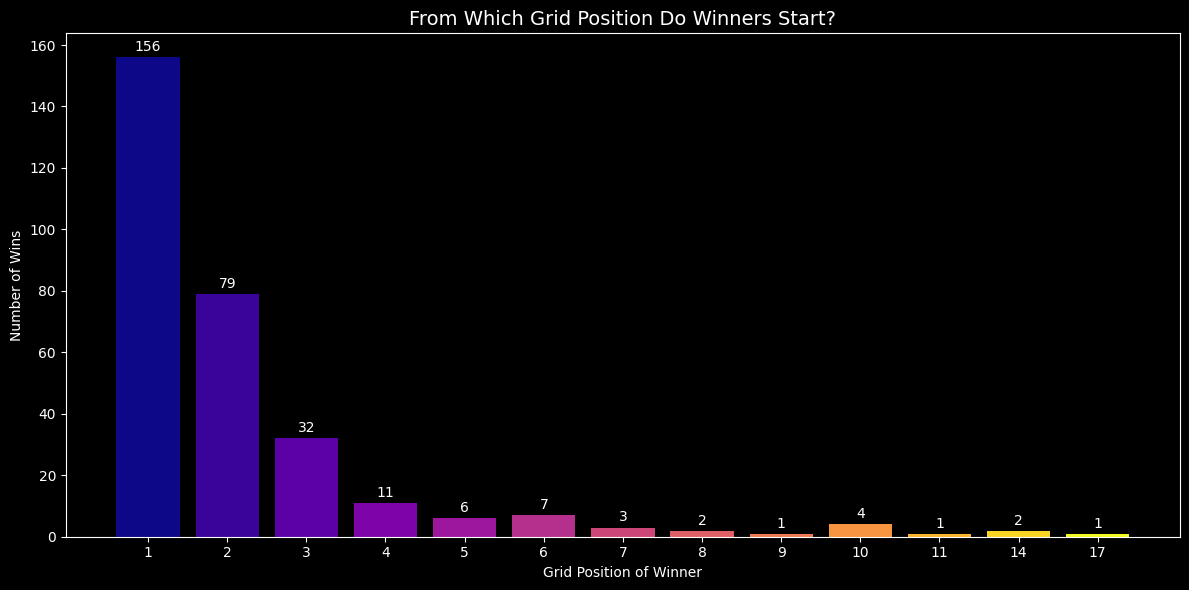

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np

# Count wins by grid position
grid_counts = final_df['winner_grid_position'].value_counts().sort_index()

# Create color gradient based on count
colors = cm.plasma(np.linspace(0, 1, len(grid_counts)))

# Set dark background
plt.style.use("dark_background")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(grid_counts.index.astype(str), grid_counts.values, color=colors)

# Bar labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval),
            ha='center', va='bottom', fontsize=10, color='white')

# Titles and labels
ax.set_xlabel("Grid Position of Winner")
ax.set_ylabel("Number of Wins")
ax.set_title("From Which Grid Position Do Winners Start?", fontsize=14)
ax.grid(False)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# 2. Number of Pit Stops vs Final Position
Pit-stop strategies play a crucial role in determining race outcomes in Formula 1. This bar chart shows how many pit stops race winners made in each Grand Prix.


*   The majority of races were won either 1 or 2 pit stops.
*   More than 2 pit stops became less and less common.

Most winning strategies in Formula 1 involve 1 or 2 pit stops, showing a balance between tire management and track position. Too few stops might sacrifice speed. And too many pit stops generally correlate with slightly worse finishing positions by wasting race time.



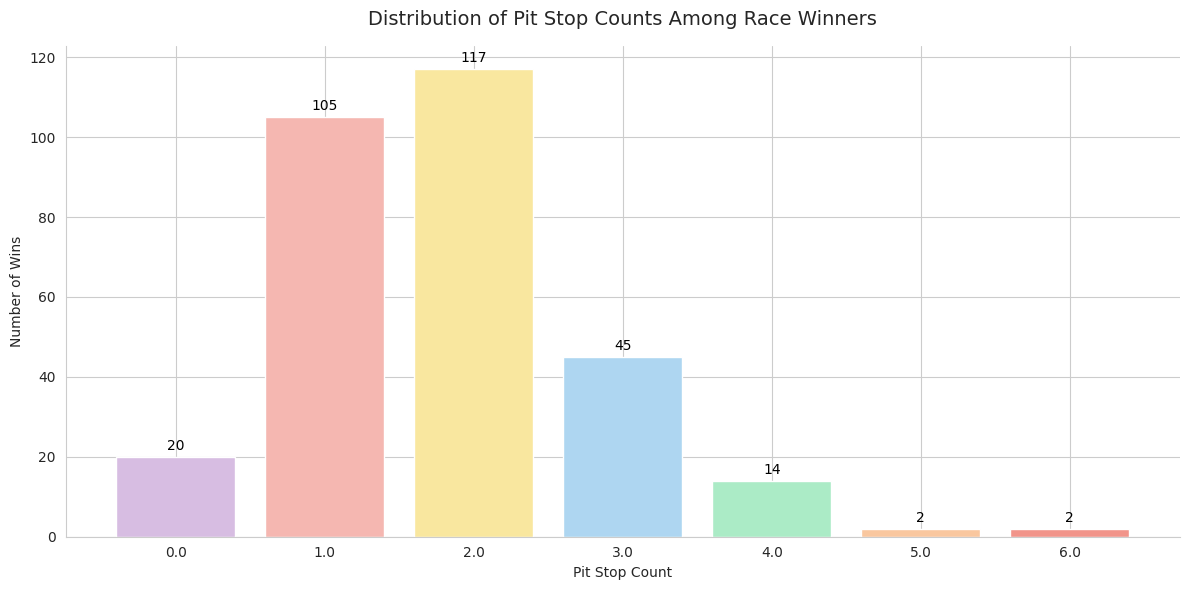

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate pit stop counts
pit_counts = final_df['pit_stop_count'].value_counts().sort_index()

# Custom pastel color palette
pastel_colors = ['#d7bde2', '#f5b7b1', '#f9e79f', '#aed6f1', '#abebc6', '#f9c79f', '#f1948a']

# Adjust color list to match unique pit stop counts
colors = pastel_colors[:len(pit_counts)]

# White background
sns.set_style("whitegrid")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(pit_counts.index.astype(str), pit_counts.values, color=colors)

# Labels on bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval),
            ha='center', va='bottom', fontsize=10, color='black')

# Titles and labels
ax.set_title('Distribution of Pit Stop Counts Among Race Winners', fontsize=14, pad=15)
ax.set_xlabel('Pit Stop Count')
ax.set_ylabel('Number of Wins')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


# 3. Driver Age vs Experience
Understanding the relationship between a driver's age or experience and their effectiveness in Formula 1 is crucial for teams when making strategic decisions regarding driver development and recruitment. I am going to focus on how a driver's age and experience correlates with their performance.

This line chart shows how race wins are distributed across different driver ages.


*   Most race wins happen between the ages of 23 and 32, with several sharp peaks. The highest number of wins is observed at ages 26 and 30, showing those as the peak performance ages in this period.
*   Race wins drop off after the early 30s, suggesting performance may decline slightly with age.


*   There are very few wins below age 20 or above age 36, showing that very young or much older drivers rarely win races.

Drivers tend to win the most races in their late 20s and early 30s, suggesting this age range aligns with the peak of both physical ability and racecraft experience.





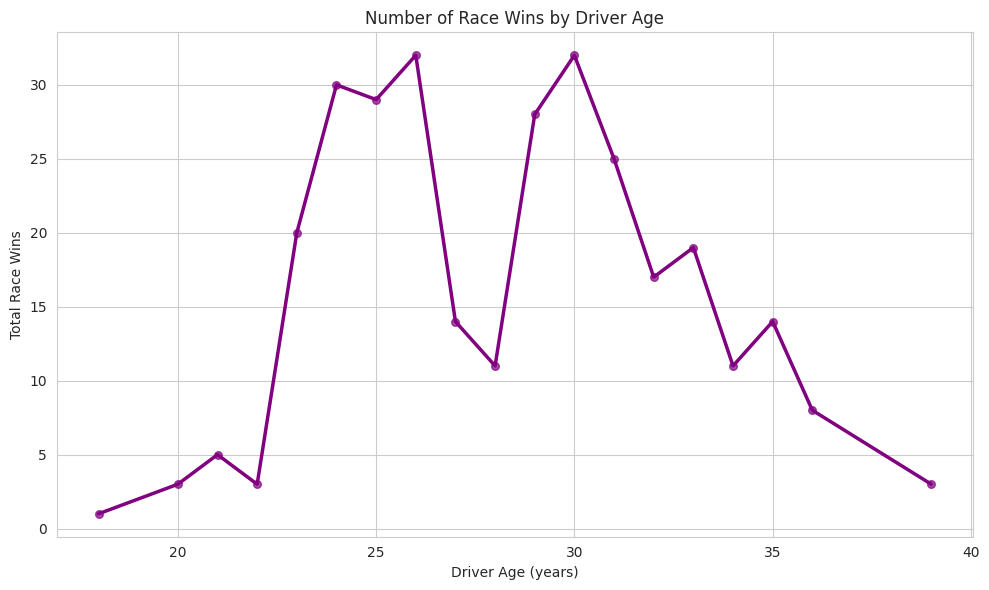

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count total wins per age
age_win_counts = final_df['driver_age'].value_counts().sort_index().reset_index()
age_win_counts.columns = ['driver_age', 'win_count']

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=age_win_counts, x='driver_age', y='win_count', color='purple', linewidth=2.5)
plt.scatter(age_win_counts['driver_age'], age_win_counts['win_count'], color='purple', s=30, alpha=0.7)

plt.title('Number of Race Wins by Driver Age')
plt.xlabel('Driver Age (years)')
plt.ylabel('Total Race Wins')
plt.grid(True)
plt.tight_layout()
plt.show()


This chart shows how many races were won by drivers at each level of experience (measured in years since their Formula 1 debut).


*   Most wins are concentrated around 6 to 10 years of experience, peaking sharply at 8 years.
*   After that, there's a steady decline in the number of wins as drivers become more experienced.


*   Very inexperienced drivers (with 1–2 years) and very experienced ones (15+ years) have significantly fewer wins.

Drivers tend to win races when they've had 6 to 10 years of experience. This supports the idea that both familiarity with the sport and physical sharpness play a role.





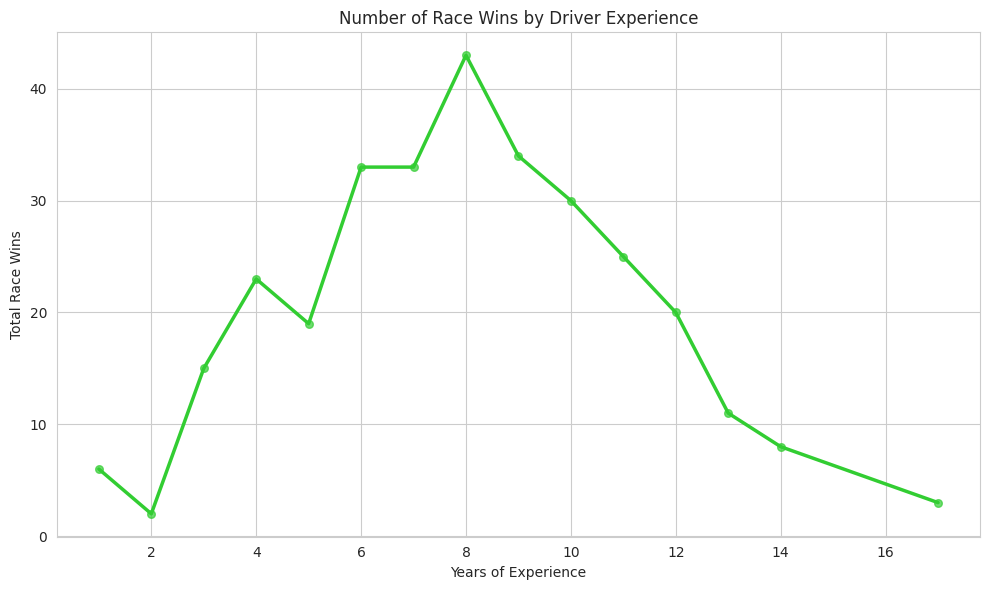

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by experience and count wins
exp_win_counts = final_df['experience'].value_counts().sort_index().reset_index()
exp_win_counts.columns = ['experience', 'win_count']

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=exp_win_counts, x='experience', y='win_count', color='limegreen', linewidth=2.5)
plt.scatter(exp_win_counts['experience'], exp_win_counts['win_count'], color='limegreen', s=30, alpha=0.7)

plt.title('Number of Race Wins by Driver Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Total Race Wins')
plt.grid(True)
plt.tight_layout()
plt.show()


This box plot visualizes the starting grid position (y-axis) of race winners based on their years of experience grouped into bins (x-axis).


*   Drivers with 0-3 and 11-15 years of experience seem to qualify slightly better on average than the others.
*   The spread (IQR) and outliers grow slightly with experience, especially in the 7-10 group, suggesting more variability in qualifying among mid-career drivers.

There’s no sharp difference in qualifying performance across experience levels. However, newer and seasoned drivers tend to start higher up the grid, which might suggest strong rookie talent and veteran consistency - while mid-career drivers show more variation.





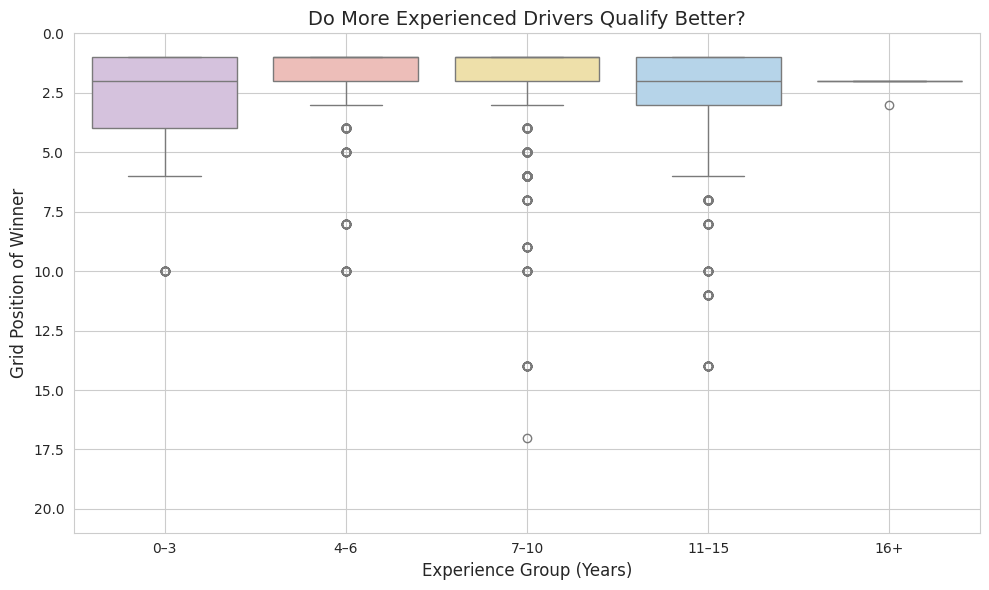

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set white background
sns.set_style("whitegrid")

# Group experience into bins (if not already done)
df['exp_group'] = pd.cut(df['experience'],
                         bins=[0, 3, 6, 10, 15, 25],
                         labels=['0–3', '4–6', '7–10', '11–15', '16+'])

# Define custom pastel color palette
pastel_palette = ['#d7bde2', '#f5b7b1', '#f9e79f', '#aed6f1', '#abebc6']  # purple, pink, yellow, blue, green

# Plot with reversed y-axis
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='exp_group', y='winner_grid_position',
            hue='exp_group', palette=pastel_palette, dodge=False)
plt.legend([], [], frameon=False)  # Hide legend

plt.xlabel('Experience Group (Years)', fontsize=12)
plt.ylabel('Grid Position of Winner', fontsize=12)
plt.title('Do More Experienced Drivers Qualify Better?', fontsize=14)
plt.ylim(21, 0)  # Reverse Y-axis: lower grid = better start
plt.grid(True)
plt.tight_layout()
plt.show()


This stacked histogram shows how race winners with different levels of experience are distributed across starting grid positions.


*   The majority of wins happen from the first few grid positions, regardless of experience.
*   Drivers in the 7-10 years of experience range have the most wins overall, especially from grid positions 1 and 2.


*   Interestingly, even newer drivers (0-3 years) are winning from front rows, suggesting rookies are competitive early in their careers.

Grid position strongly influences race outcomes, and mid-experience drivers (4-10 years) tend to dominate the front rows.





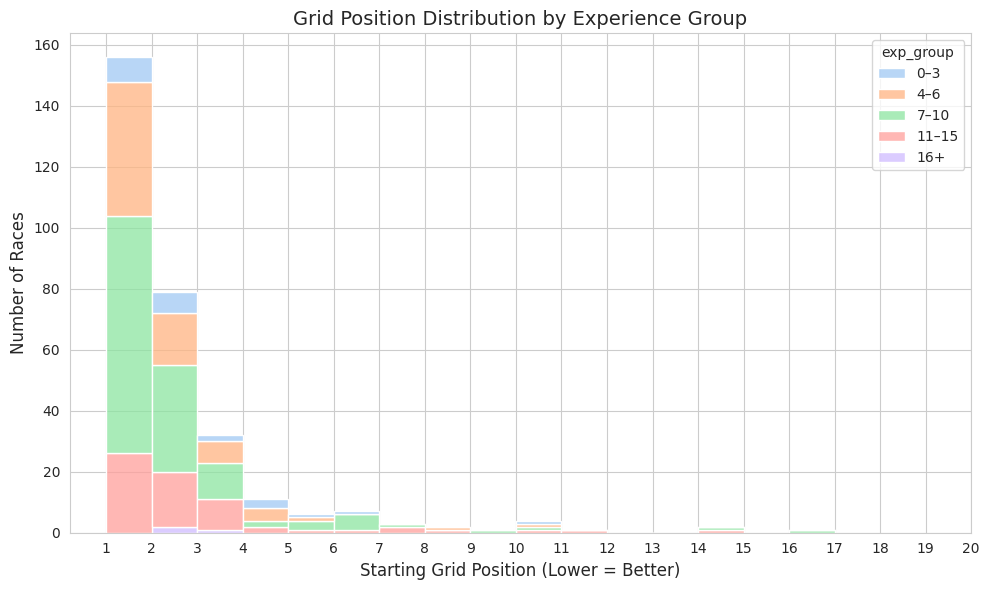

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Bin experience levels
final_df['exp_group'] = pd.cut(final_df['experience'],
                                bins=[0, 3, 6, 10, 15, 25],
                                labels=['0–3', '4–6', '7–10', '11–15', '16+'])

# Drop NaNs
exp_grid_df = final_df[['exp_group', 'winner_grid_position']].dropna()

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=exp_grid_df, x='winner_grid_position', hue='exp_group',
             multiple='stack', palette='pastel', binwidth=1)

# Labels
plt.title('Grid Position Distribution by Experience Group', fontsize=14)
plt.xlabel('Starting Grid Position (Lower = Better)', fontsize=12)
plt.ylabel('Number of Races', fontsize=12)
plt.xticks(range(1, 21))
plt.tight_layout()
plt.show()


# 4. Rainy vs Dry Race Outcomes
This bar chart shows how many F1 races between 2010 - 2024 were won in dry vs. rainy weather conditions.


*   Out of 300 total races, more races were won in dry conditions (≈162) than in rainy conditions (≈130).
*   This is expected, as dry races are more frequent overall in F1 seasons.

The graph helps us confirm that weather conditions influence race dynamics, but not to the extent of completely leveling the playing field. Dry-weather races still see more victories overall.



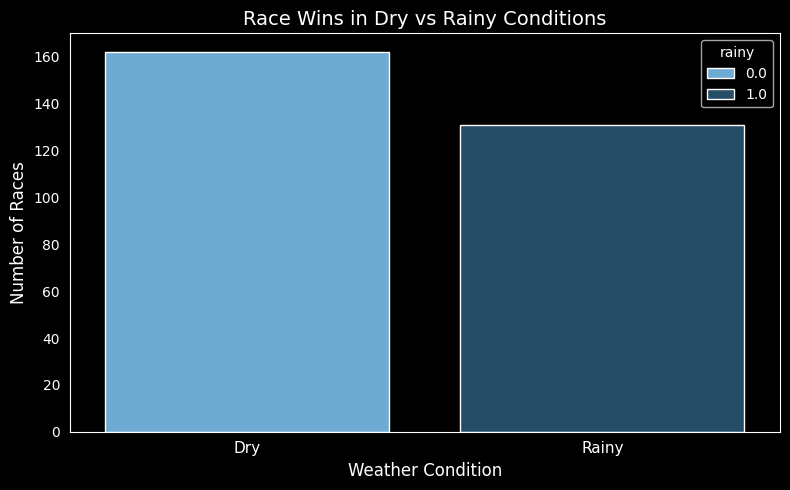

In [7]:
plt.style.use("dark_background")

blue_palette = ['#5dade2', '#1b4f72']  # Light & dark blue

# Only include 0 and 1
filtered_df = final_df[final_df['rainy'].isin([0, 1])]

plt.figure(figsize=(8, 5))
sns.countplot(data=filtered_df, x='rainy', hue='rainy', palette=blue_palette)

plt.xticks([0, 1], ['Dry', 'Rainy'], fontsize=11)
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Number of Races', fontsize=12)
plt.title('Race Wins in Dry vs Rainy Conditions', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()


This heatmap visualizes how strongly four numerical factors are related to one another based on data from F1 race winners (2010-2024):


*   Driver Age
*   Experience

*   Grid Position
*   Pit Stops

Values range from -1 (strong negative correlation) to 1 (strong positive correlation), with 0 meaning no correlation.

This heatmap shows how strongly four race-related variables—driver age, experience, starting grid position, and number of pit stops are correlated with each other for Formula 1 winners.

The most noticeable relationship is the very strong positive correlation between driver age and experience. This is expected, since older drivers naturally have more years of racing behind them. Aside from that, the other variables show very weak or no correlation.

For example, starting grid position is not strongly related to experience or age, suggesting that older or more experienced drivers don't necessarily qualify better. Similarly, the number of pit stops doesn’t seem to be connected to any of the other variables, pit strategy appears to be independent of age, experience, and even starting position.

Overall, the heatmap tells us that most of these factors vary independently, and each one should be evaluated on its own when analyzing its impact on race outcomes.


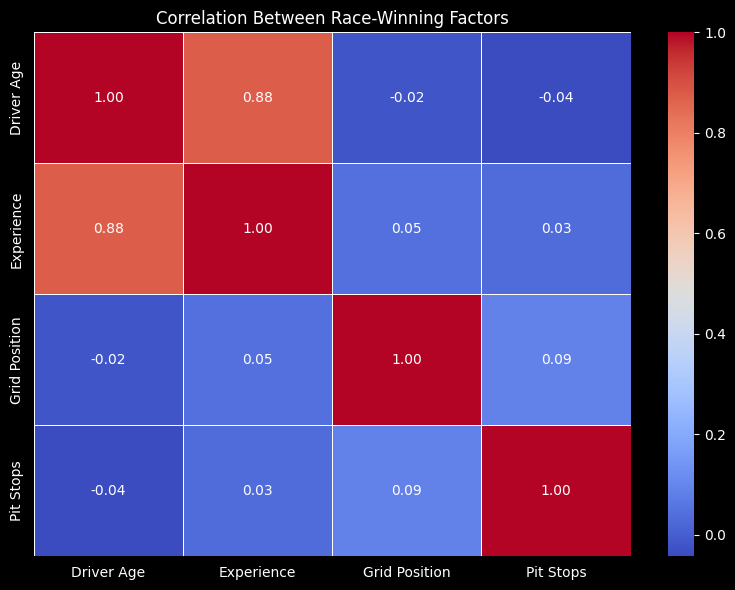

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns to analyze
corr_df = final_df[['driver_age', 'experience', 'winner_grid_position', 'pit_stop_count']].copy()

# Optional: rename for display clarity
corr_df.rename(columns={
    'driver_age': 'Driver Age',
    'experience': 'Experience',
    'winner_grid_position': 'Grid Position',
    'pit_stop_count': 'Pit Stops'
}, inplace=True)

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Race-Winning Factors")
plt.tight_layout()
plt.show()


# 1. Hypothesis Test: Grid Position of Winners vs Non-Winners
These two plots illustrate the distributions of starting grid positions for winners and non-winners, helping us decide which statistical test is appropriate for comparing the two.

First Plot: Winners

*   The distribution is heavily skewed to the left (toward lower grid positions).
*   Most winners start from the first few grid spots, especially grid position 1.
*   This is a non-normal distribution, clearly right-skewed.

Second Plot: Non-Winners

*   The distribution is more uniform and flat, spreading across many grid positions.
*   Again, the distribution is not normal, and definitely different from that of winners.

Since neither distribution is normal, and the shapes differ a lot, we cannot use a t-test (which assumes normality and similar shape). Instead, we use the Mann-Whitney U test, a non-parametric test that compares medians and distribution ranks.







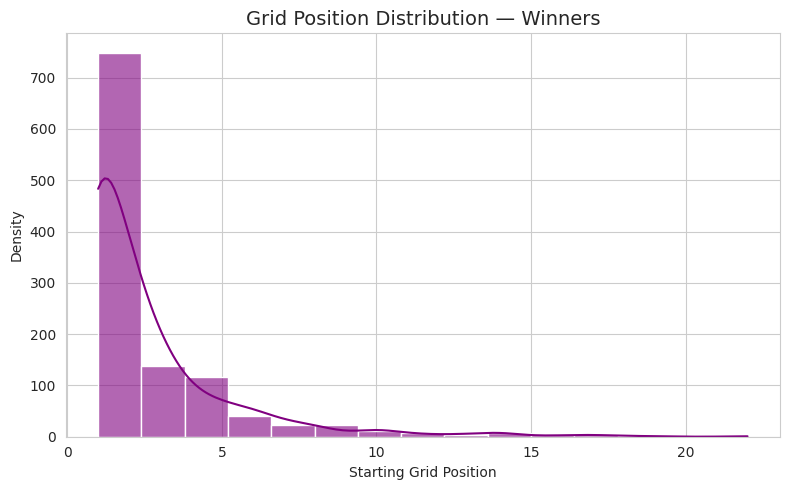

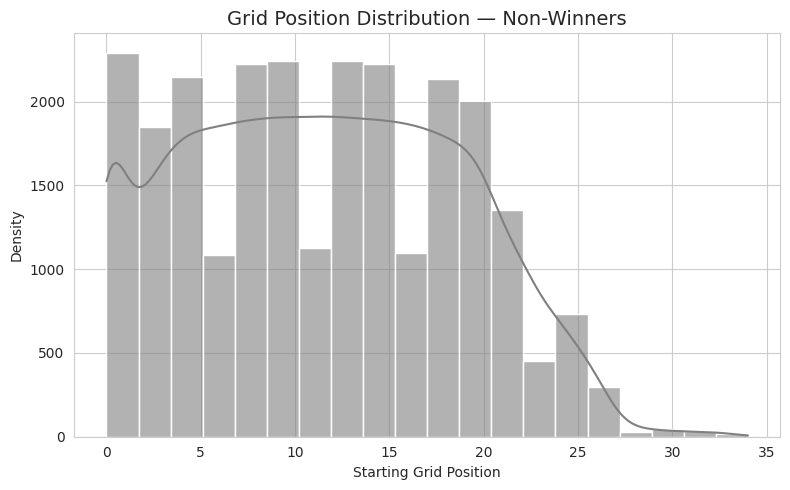

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
winners = results[results['positionOrder'] == 1]['grid']
non_winners = results[results['positionOrder'] > 1]['grid']

sns.set_style("whitegrid")

# Plot: Winners
plt.figure(figsize=(8, 5))
sns.histplot(winners, kde=True, color='purple', bins=15, alpha=0.6)
plt.title('Grid Position Distribution — Winners', fontsize=14)
plt.xlabel('Starting Grid Position')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Plot: Non-Winners
plt.figure(figsize=(8, 5))
sns.histplot(non_winners, kde=True, color='gray', bins=20, alpha=0.6)
plt.title('Grid Position Distribution — Non-Winners', fontsize=14)
plt.xlabel('Starting Grid Position')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


Null Hypothesis (H₀):
There is no difference in the grid positions of winners and non-winners.
(Winners don't actually start ahead of others.)

Alternative Hypothesis (H₁):
Winners tend to start from better (lower) grid positions than non-winners.

U-statistic = 4,016,410.00
This is the test statistic computed by the Mann-Whitney U algorithm. It represents the number of times a value in the winner group precedes a value in the non-winner group in the ranked data.

p-value = 0.0000
This means the probability of observing this result, if the null hypothesis were true, is effectively zero.

Because the p-value is less than 0.05, we reject the null hypothesis.

Conclusion: There is a statistically significant difference between the grid positions of winners and non-winners.

Winners in F1 do tend to start from better grid positions, in other words qualifying near the front significantly increases the chances of winning.


In [16]:
from scipy.stats import mannwhitneyu

# Grid positions for winners and non-winners
winners = results[results['positionOrder'] == 1]['grid']
non_winners = results[results['positionOrder'] > 1]['grid']

# Run the Mann-Whitney U test (one-tailed: winners expected to start ahead)
stat, p = mannwhitneyu(winners, non_winners, alternative='less')

# Print result and interpretation
print(f"Mann-Whitney U Test — Grid Position (Winners vs Non-Winners)")
print(f"U-statistic = {stat:.2f}")
print(f"p-value     = {p:.4f}\n")

if p < 0.05:
    print("Result: Statistically significant difference.")
    print("Interpretation: Winners tend to start from 'better (lower)' grid positions.")
else:
    print("Result: No statistically significant difference.")
    print("Interpretation: There is 'no evidence' that winners start from better grid positions.")


Mann-Whitney U Test — Grid Position (Winners vs Non-Winners)
U-statistic = 4016410.00
p-value     = 0.0000

Result: Statistically significant difference.
Interpretation: Winners tend to start from 'better (lower)' grid positions.


This visualization clearly supports the statistical test results:

Winners tend to start from significantly better (lower) positions.

The median grid position for winners is close to 2, while for non-winners it's around 11.

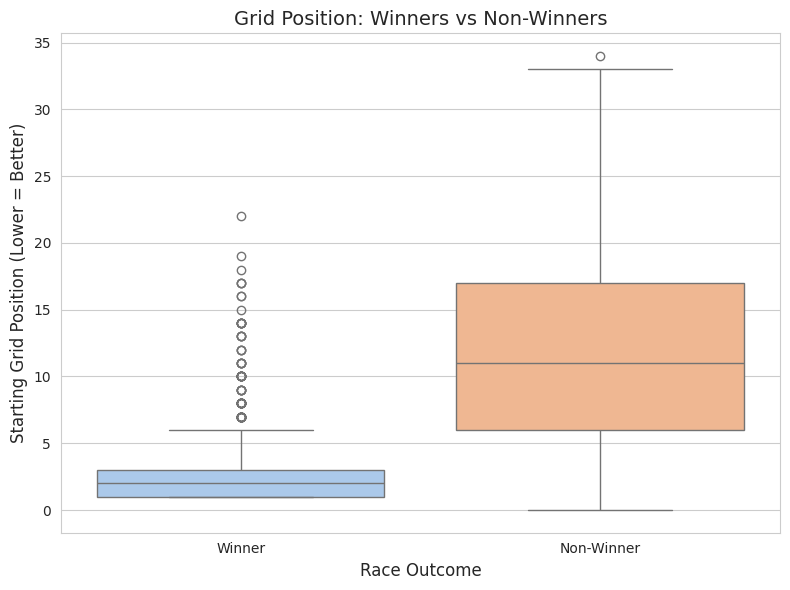

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add win status label (if not already added)
results['win_status'] = results['positionOrder'].apply(lambda x: 'Winner' if x == 1 else 'Non-Winner')

# Set white background
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=results, x='win_status', y='grid', hue='win_status', palette='pastel', dodge=False)
plt.legend([],[], frameon=False)  # Hide redundant legend

# Labels
plt.title('Grid Position: Winners vs Non-Winners', fontsize=14)
plt.xlabel('Race Outcome', fontsize=12)
plt.ylabel('Starting Grid Position (Lower = Better)', fontsize=12)
plt.tight_layout()
plt.show()


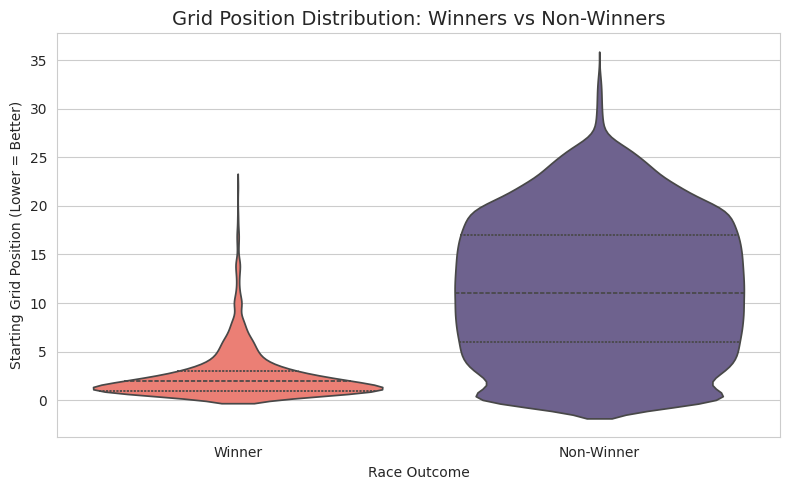

In [24]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=results, x='win_status', y='grid', hue='win_status', palette=['#FF6F61', '#6B5B95'], inner='quartile')
plt.title('Grid Position Distribution: Winners vs Non-Winners', fontsize=14)
plt.xlabel('Race Outcome')
plt.ylabel('Starting Grid Position (Lower = Better)')
plt.tight_layout()
plt.show()


# 2. Hypothesis Test: Pit Stops of Winners vs Non-Winners
Winner Plot (Left):

*   The distribution is not symmetric.
*   There is a sharp peak at 2 pit stops, and then a long tail towards 3, 4, 5.
*   This is a right-skewed distribution, not normal.

Non-Winner Plot (Right):

*   The values are more spread out with multiple peaks.
*   Still not bell-shaped, not normal.

Since neither group (winners nor non-winners) shows normality, we cannot safely use a t-test which assumes normal distributions.
Instead, we choose the Mann-Whitney U test.







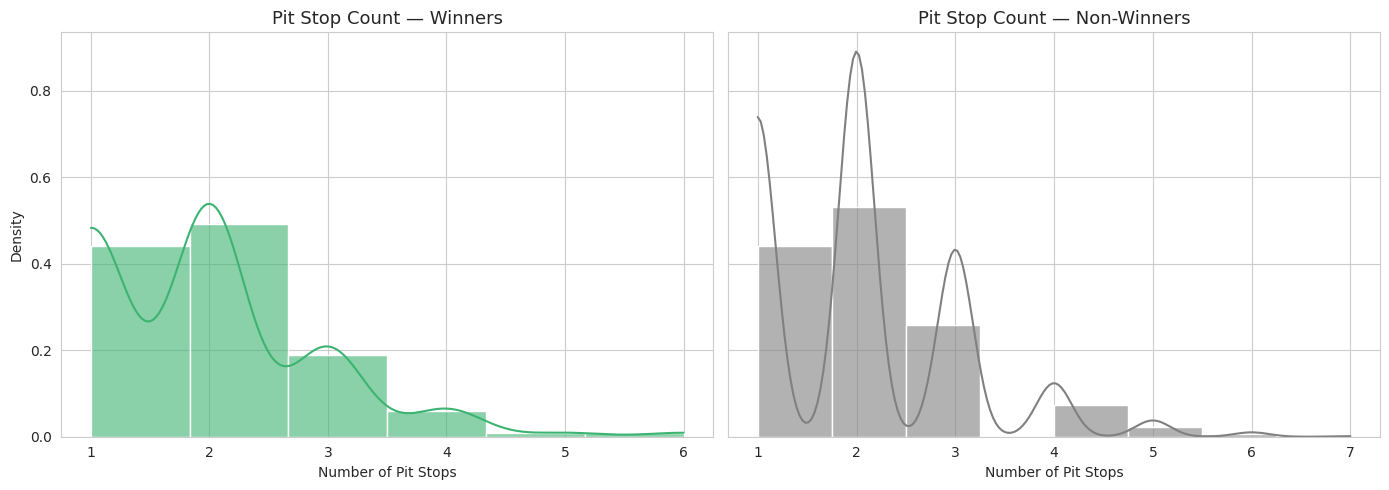

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge total pit stop count per driver per race
pit_counts = pit_stops.groupby(['raceId', 'driverId']).size().reset_index(name='pit_stop_count')
results_with_pits = results.merge(pit_counts, on=['raceId', 'driverId'], how='left')

# Extract values
winners_pits = results_with_pits[results_with_pits['positionOrder'] == 1]['pit_stop_count'].dropna()
non_winners_pits = results_with_pits[results_with_pits['positionOrder'] > 1]['pit_stop_count'].dropna()

# Plot
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Winners
sns.histplot(winners_pits, kde=True, color='mediumseagreen', bins=6, alpha=0.6, ax=axs[0], stat='density')
axs[0].set_title('Pit Stop Count — Winners', fontsize=13)
axs[0].set_xlabel('Number of Pit Stops')
axs[0].set_ylabel('Density')

# Non-Winners
sns.histplot(non_winners_pits, kde=True, color='gray', bins=8, alpha=0.6, ax=axs[1], stat='density')
axs[1].set_title('Pit Stop Count — Non-Winners', fontsize=13)
axs[1].set_xlabel('Number of Pit Stops')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()


Null Hypothesis (H₀):
There is no difference in the number of pit stops between winners and non-winners. (Pit strategy is not significantly related to winning.)

Alternative Hypothesis (H₁):
Winners make a different number of pit stops than non-winners.

U-statistic = 707,750.50

p-value = 0.0654

Because the p-value is greater than 0.05, we fail to reject the null hypothesis.

There is no statistically significant difference in the number of pit stops between winners and non-winners. This suggests that pit stop count alone does not clearly determine race outcomes.



In [17]:
from scipy.stats import mannwhitneyu

# Get total pit stops per driver per race
pit_counts = pit_stops.groupby(['raceId', 'driverId']).size().reset_index(name='pit_stop_count')

# Merge into results
results_merged = results.merge(pit_counts, on=['raceId', 'driverId'], how='left')

# Extract pit stop counts for winners vs non-winners
winners_pits = results_merged[results_merged['positionOrder'] == 1]['pit_stop_count']
non_winners_pits = results_merged[results_merged['positionOrder'] > 1]['pit_stop_count']

# Mann-Whitney U Test (two-tailed, because we don't assume direction)
stat, p = mannwhitneyu(winners_pits.dropna(), non_winners_pits.dropna(), alternative='two-sided')

# Print result and interpretation
print(f"Mann-Whitney U Test — Pit Stops (Winners vs Non-Winners)")
print(f"U-statistic = {stat:.2f}")
print(f"p-value     = {p:.4f}\n")

if p < 0.05:
    print("Result: Statistically significant difference.")
    print("Interpretation: Winners and non-winners make a 'different' number of pit stops.")
else:
    print("Result: No statistically significant difference.")
    print("Interpretation: There is 'no evidence' that pit stop counts differ between winners and non-winners.")


Mann-Whitney U Test — Pit Stops (Winners vs Non-Winners)
U-statistic = 707750.50
p-value     = 0.0654

Result: No statistically significant difference.
Interpretation: There is 'no evidence' that pit stop counts differ between winners and non-winners.


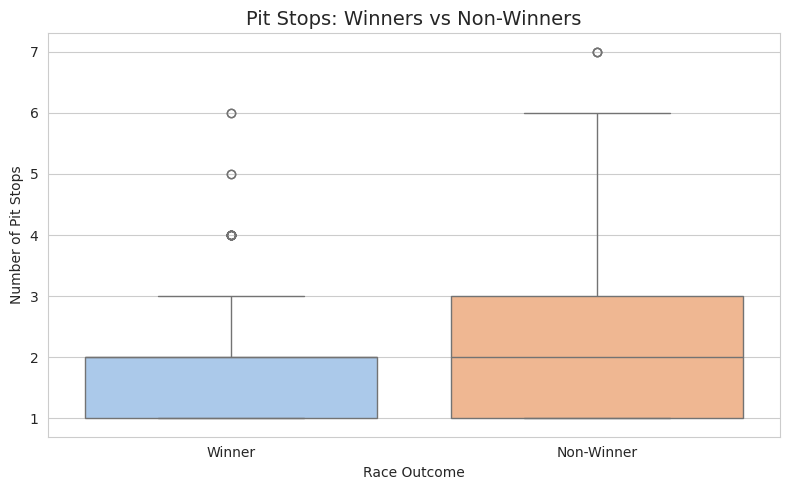

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Set white grid style
sns.set_style("whitegrid")

# 2. Box Plot — Pit Stops: Winners vs Non-Winners
# Merge pit stop data
pit_counts = pit_stops.groupby(['raceId', 'driverId']).size().reset_index(name='pit_stop_count')
results_pits = results.merge(pit_counts, on=['raceId', 'driverId'], how='left')

plt.figure(figsize=(8, 5))
sns.boxplot(data=results_pits, x='win_status', y='pit_stop_count', hue='win_status', palette='pastel')
plt.title('Pit Stops: Winners vs Non-Winners', fontsize=14)
plt.xlabel('Race Outcome')
plt.ylabel('Number of Pit Stops')
plt.tight_layout()
plt.show()


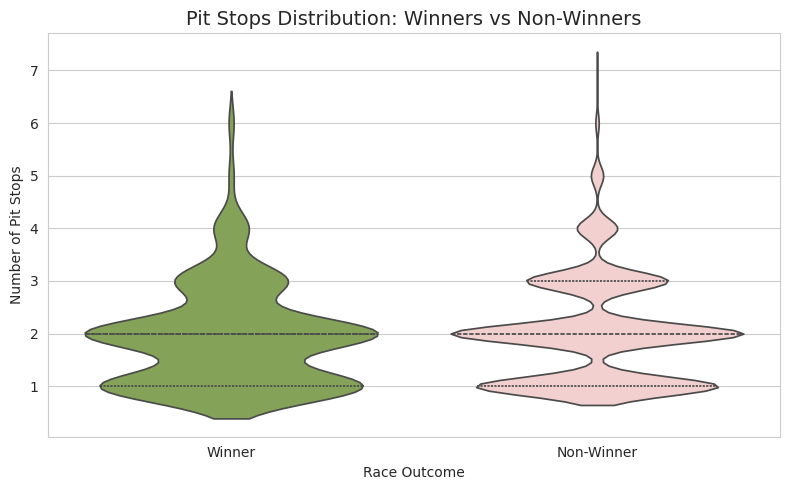

In [25]:
# Make sure pit stop count merged as before
results_pits = results.merge(pit_counts, on=['raceId', 'driverId'], how='left')

plt.figure(figsize=(8, 5))
sns.violinplot(data=results_pits, x='win_status', y='pit_stop_count', hue='win_status', palette=['#88B04B', '#F7CAC9'], inner='quartile')
plt.title('Pit Stops Distribution: Winners vs Non-Winners', fontsize=14)
plt.xlabel('Race Outcome')
plt.ylabel('Number of Pit Stops')
plt.tight_layout()
plt.show()


# 3. Hypothesis Test: Driver Experience of Winners vs Non-Winners
Winners (left): A noticeable right-skew, many winners tend to have 10+ years of experience.

Non-Winners (right): Also somewhat skewed but spread out more evenly, with slightly more density around 10-12 years.

Neither distribution appears normal.

Both are skewed, with more mass toward the right for winners.

Because the experience data does not follow a normal distribution and the sample sizes are different, we cannot safely use a t-test.

Instead, we use the Mann-Whitney U test.

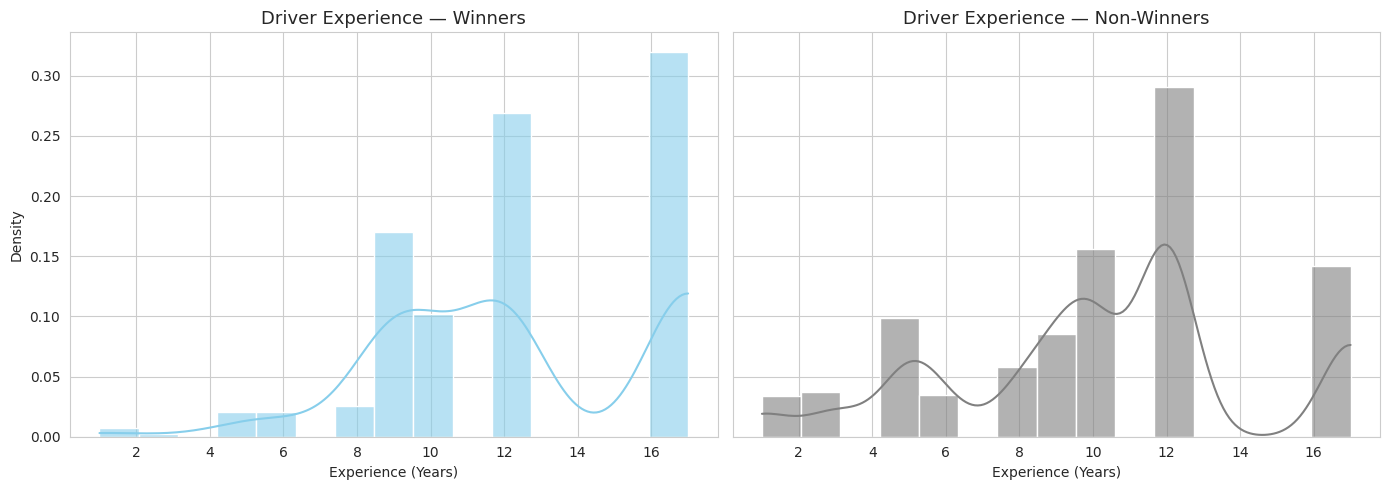

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract experience for winners and non-winners
exp_win = results[results['positionOrder'] == 1]['experience'].dropna()
exp_non = results[results['positionOrder'] > 1]['experience'].dropna()

# Set style
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot: Winners
sns.histplot(exp_win, kde=True, color='skyblue', bins=15, alpha=0.6, ax=axs[0], stat='density')
axs[0].set_title('Driver Experience — Winners', fontsize=13)
axs[0].set_xlabel('Experience (Years)')
axs[0].set_ylabel('Density')

# Plot: Non-Winners
sns.histplot(exp_non, kde=True, color='gray', bins=15, alpha=0.6, ax=axs[1], stat='density')
axs[1].set_title('Driver Experience — Non-Winners', fontsize=13)
axs[1].set_xlabel('Experience (Years)')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()


Null Hypothesis (H₀): There is no difference in experience between winners and non-winners.
(Winners are not more experienced than others.)

Alternative Hypothesis (H₁): Winners tend to be more experienced than non-winners.

U-statistic: 902,030.00

p-value: 0.0000

Since the p-value is less than 0.05, we reject the null hypothesis. There is a statistically significant difference.

Formula 1 winners from 2010 to 2024 tend to be more experienced than non-winners. Experience seems to play a meaningful role in winning races.

This shows that experienced drivers tend to win more races, showing the value of their knowledge and familiarity with the sport. Experience likely contributes to better race strategies, decision-making under pressure and consistent performance.



In [18]:
from scipy.stats import mannwhitneyu

# Map experience into results (from final_df)
experience_map = final_df.set_index('winner_driverId')['experience'].to_dict()
results['experience'] = results['driverId'].map(experience_map)

# Extract groups
exp_win = results[results['positionOrder'] == 1]['experience'].dropna()
exp_non = results[results['positionOrder'] > 1]['experience'].dropna()

# Mann-Whitney U (one-tailed — we're testing if winners are MORE experienced)
stat, p = mannwhitneyu(exp_win, exp_non, alternative='greater')

# Output
print(f"Mann-Whitney U Test — Experience (Winners vs Non-Winners)")
print(f"U-statistic = {stat:.2f}")
print(f"p-value     = {p:.4f}\n")

if p < 0.05:
    print("Result: Statistically significant difference.")
    print("Interpretation: Winners tend to be 'more experienced' than non-winners.")
else:
    print("Result: No statistically significant difference.")
    print("Interpretation: There is 'no evidence' that winners are more experienced.")


Mann-Whitney U Test — Experience (Winners vs Non-Winners)
U-statistic = 902030.00
p-value     = 0.0000

Result: Statistically significant difference.
Interpretation: Winners tend to be 'more experienced' than non-winners.


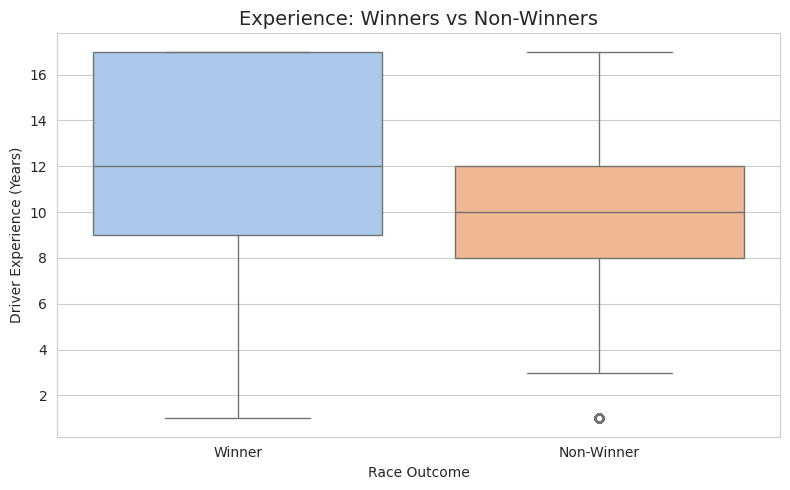

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Set white grid style
sns.set_style("whitegrid")


# 3. Box Plot — Experience: Winners vs Non-Winners
# Map experience
experience_map = final_df.set_index('winner_driverId')['experience'].to_dict()
results['experience'] = results['driverId'].map(experience_map)

plt.figure(figsize=(8, 5))
sns.boxplot(data=results, x='win_status', y='experience', hue='win_status', palette='pastel')
plt.title('Experience: Winners vs Non-Winners', fontsize=14)
plt.xlabel('Race Outcome')
plt.ylabel('Driver Experience (Years)')
plt.tight_layout()
plt.show()


# 4. Hypothesis Test: Driver Age of Winners vs Non-Winners
Winners (left): Most winners tend to fall between ages 25 and 32, with a visible peak around 26-30.

Non-Winners (right): Ages are more spread out, and the distribution is a bit more symmetric with a longer tail after age 30.

Although both distributions are not extremely skewed, they are not perfectly normal either, especially the winners’ group, which shows a slight right skew and a visible multi-modal shape.

This visual check tells us that we should not assume a normal distribution.

Since the distributions are not normal and sample sizes may vary, Mann-Whitney U is more appropriate than a t-test.

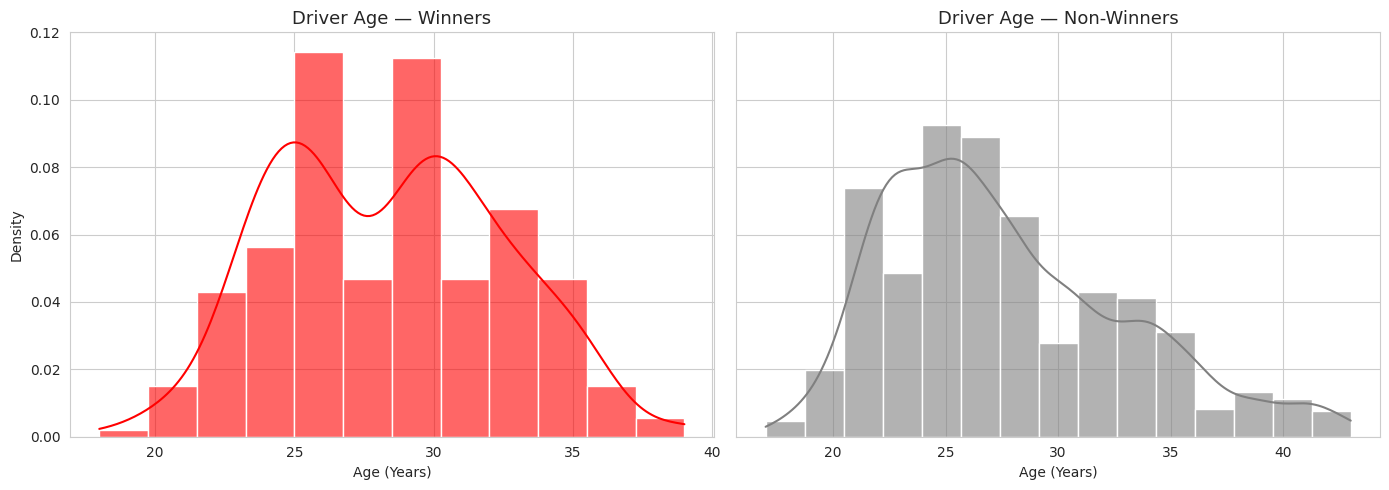

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare age data
age_win = results[results['positionOrder'] == 1]['driver_age'].dropna()
age_non = results[results['positionOrder'] > 1]['driver_age'].dropna()

# Plot setup
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot: Winners
sns.histplot(age_win, kde=True, color='red', bins=12, alpha=0.6, ax=axs[0], stat='density')
axs[0].set_title('Driver Age — Winners', fontsize=13)
axs[0].set_xlabel('Age (Years)')
axs[0].set_ylabel('Density')

# Plot: Non-Winners
sns.histplot(age_non, kde=True, color='gray', bins=15, alpha=0.6, ax=axs[1], stat='density')
axs[1].set_title('Driver Age — Non-Winners', fontsize=13)
axs[1].set_xlabel('Age (Years)')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()


Null Hypothesis (H₀):
There is no difference in the driver ages of winners and non-winners.
(In other words, age does not affect race outcomes.)

Alternative Hypothesis (H₁):
There is a difference in the driver ages of winners and non-winners.
(Driver age does influence who wins races.)

U-statistic = 1,068,181.00

p-value = 0.0000

Because the p-value is less than 0.05, we reject the null hypothesis. There is a statistically significant difference in driver ages between winners and non-winners.





In [19]:
from scipy.stats import mannwhitneyu

# Get race dates and driver DOBs
races['date'] = pd.to_datetime(races['date'])
drivers['dob'] = pd.to_datetime(drivers['dob'])

# Merge race dates into results
results = results.merge(races[['raceId', 'date']], on='raceId', how='left')

# Map DOB into results
results['dob'] = results['driverId'].map(drivers.set_index('driverId')['dob'])

# Calculate driver age at race time
results['driver_age'] = ((results['date'] - results['dob']).dt.days // 365)

# Extract ages
age_win = results[results['positionOrder'] == 1]['driver_age'].dropna()
age_non = results[results['positionOrder'] > 1]['driver_age'].dropna()

# Mann-Whitney U test (two-sided)
stat, p = mannwhitneyu(age_win, age_non, alternative='two-sided')

# Output + interpretation
print(f"Mann-Whitney U Test — Driver Age (Winners vs Non-Winners)")
print(f"U-statistic = {stat:.2f}")
print(f"p-value     = {p:.4f}\n")

if p < 0.05:
    print("Result: Statistically significant difference.")
    print("Interpretation: Driver 'age' is significantly different between winners and non-winners.")
else:
    print("Result: No statistically significant difference.")
    print("Interpretation: There is 'no evidence' that driver age affects winning.")


Mann-Whitney U Test — Driver Age (Winners vs Non-Winners)
U-statistic = 1068181.00
p-value     = 0.0000

Result: Statistically significant difference.
Interpretation: Driver 'age' is significantly different between winners and non-winners.


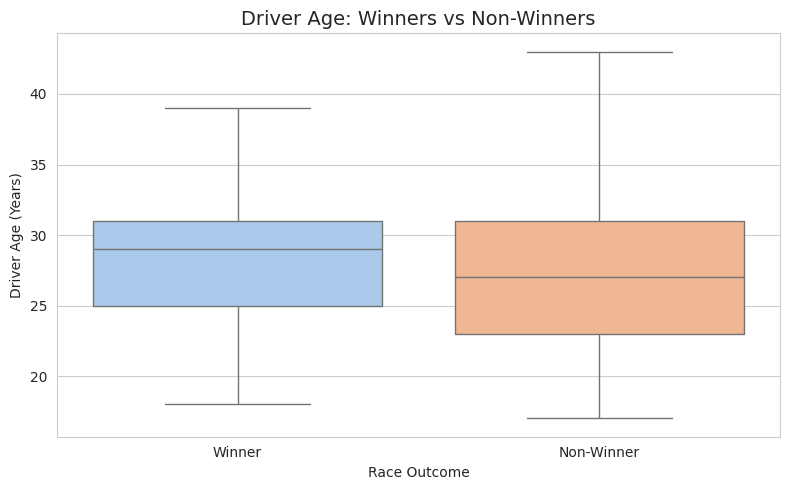

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Set white grid style
sns.set_style("whitegrid")

# 4. Box Plot — Driver Age: Winners vs Non-Winners
# Map driver age
races['date'] = pd.to_datetime(races['date'])
drivers['dob'] = pd.to_datetime(drivers['dob'])
results = results.merge(races[['raceId', 'date']], on='raceId', how='left')
results['dob'] = results['driverId'].map(drivers.set_index('driverId')['dob'])
results['driver_age'] = ((results['date'] - results['dob']).dt.days // 365)

plt.figure(figsize=(8, 5))
sns.boxplot(data=results, x='win_status', y='driver_age', hue='win_status', palette='pastel')
plt.title('Driver Age: Winners vs Non-Winners', fontsize=14)
plt.xlabel('Race Outcome')
plt.ylabel('Driver Age (Years)')
plt.tight_layout()
plt.show()

# 5. Hypothesis Test: Experience vs Starting Grid Position
Pearson correlation assumes a linear relationship and normally distributed variables.

But grid positions and experience may not be linearly related and may have outliers.

So we use Spearman, which checks for a monotonic trend

Null Hypothesis (H₀):
There is no correlation between driver experience and grid position. (ρ = 0)

Alternative Hypothesis (H₁):
There is a correlation between driver experience and grid position. (ρ ≠ 0)

Spearman r = 0.05

p-value = 0.3396

Since the p-value is greater than 0.05, we fail to reject the null hypothesis.

There is no statistically significant relationship between driver experience and grid position.

Even though we might expect experienced drivers to qualify better, this analysis shows that experience alone doesn’t predict grid position in a meaningful way. There may be other factors (like team performance, car upgrades, track characteristics) that play a much larger role in determining grid position.

In [20]:
from scipy.stats import spearmanr

# Drop missing values
valid = final_df[['experience', 'winner_grid_position']].dropna()

# Spearman correlation
corr, p = spearmanr(valid['experience'], valid['winner_grid_position'])

# Output and interpretation
print(f"Spearman Correlation — Experience vs Grid Position")
print(f"Spearman r = {corr:.2f}")
print(f"p-value    = {p:.4f}\n")

if p < 0.05:
    direction = "negative" if corr < 0 else "positive"
    print("Result: Statistically significant correlation.")
    print(f"Interpretation: There is a '{direction} correlation' between experience and grid position.")
    if corr < 0:
        print("Insight: More experienced drivers tend to start 'closer to the front'.")
    else:
        print("Insight: Surprisingly, more experience is associated with 'worse' grid positions.")
else:
    print("Result: No statistically significant correlation.")
    print("Interpretation: There is 'no clear relationship' between experience and grid position.")


Spearman Correlation — Experience vs Grid Position
Spearman r = 0.05
p-value    = 0.3396

Result: No statistically significant correlation.
Interpretation: There is 'no clear relationship' between experience and grid position.


This plot helps us visualize the relationship between a driver's experience and their starting grid position.

*   Each blue dot represents a race winner, showing their experience (x-axis) and starting grid position (y-axis).
*   The orange regression line tries to fit a linear trend through the data.

The scatter is very wide, and the orange line is nearly flat.

This matches the Spearman correlation result:
-> Spearman r = 0.05, p = 0.3396 (not significant)


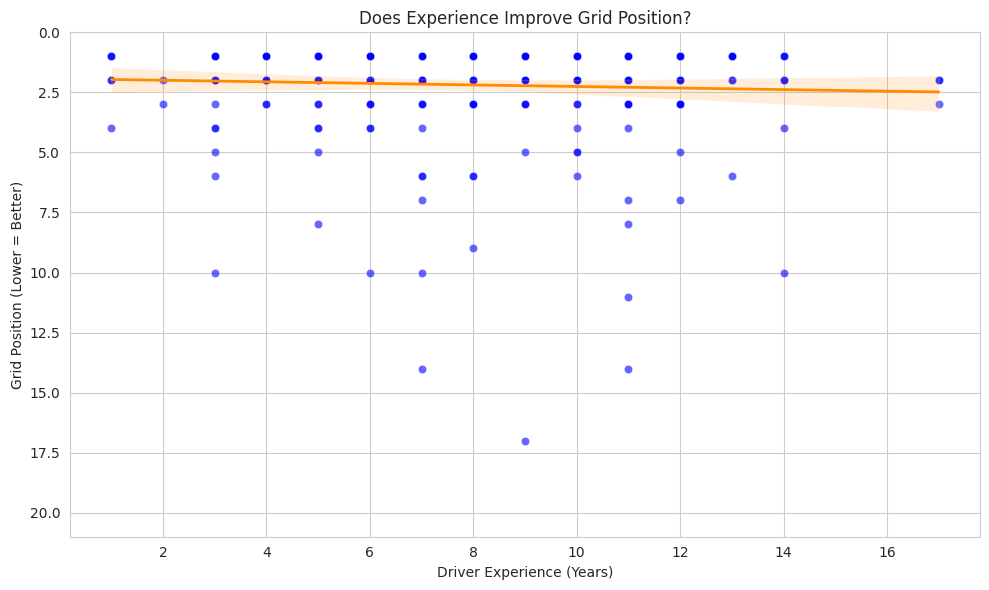

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Clean data
valid = final_df[['experience', 'winner_grid_position']].dropna()

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=valid, x='experience', y='winner_grid_position', color='blue', alpha=0.6)
sns.regplot(data=valid, x='experience', y='winner_grid_position', scatter=False, color='darkorange', line_kws={"linewidth": 2})

plt.title('Does Experience Improve Grid Position?')
plt.xlabel('Driver Experience (Years)')
plt.ylabel('Grid Position (Lower = Better)')
plt.ylim(21, 0)  # Reverse y-axis
plt.grid(True)
plt.tight_layout()
plt.show()


# 6. Hypothesis Test: Weather vs Winning
Because both weather and race outcome are categorical variables, we use a Chi-Square test of independence.

Null Hypothesis (H₀): Weather condition and race outcome are independent (rain has no effect on whether someone wins).

Alternative Hypothesis (H₁): Weather condition and race outcome are dependent (rain does affect winning chances).

Chi² = 0.04

p-value = 0.9809 Very high

Degrees of freedom = 2

Since the p-value (0.9809) is way above 0.05, we fail to reject the null hypothesis.

Conclusion: There is no statistically significant relationship between weather condition and race outcome.
In other words, drivers are equally likely to win in dry or rainy races, based on this data, rain does not impact the chance of winning.


In [21]:
import pandas as pd
from scipy.stats import chi2_contingency

# Step 1: Create a full list of drivers in each race with weather data
# Assume results already has raceId and positionOrder, and final_df has weather
weather_map = final_df.set_index('raceId')['rainy'].to_dict()
results['rainy'] = results['raceId'].map(weather_map)

# Step 2: Label winners vs non-winners
results['win_status'] = results['positionOrder'].apply(lambda x: 'Winner' if x == 1 else 'Non-Winner')

# Step 3: Contingency table (weather vs win status)
contingency = pd.crosstab(results['rainy'], results['win_status'])

# Step 4: Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency)

# Output
print("Chi-Square Test — Weather vs Race Outcome")
print(f"Chi² = {chi2:.2f}")
print(f"p-value = {p:.4f}")
print(f"Degrees of freedom = {dof}")
print("\nContingency Table:")
print(contingency)
print()

# Interpretation
if p < 0.05:
    print("Result: Statistically significant relationship.")
    print("Interpretation: Weather 'does affect' the likelihood of winning.")
else:
    print("Result: No statistically significant relationship.")
    print("Interpretation: There's 'no evidence' that weather impacts race winning probability.")


Chi-Square Test — Weather vs Race Outcome
Chi² = 0.04
p-value = 0.9809
Degrees of freedom = 2

Contingency Table:
win_status  Non-Winner  Winner
rainy                         
0.0               3269     162
1.0               2634     131
unknown            228      12

Result: No statistically significant relationship.
Interpretation: There's 'no evidence' that weather impacts race winning probability.
